In [ ]:
from google.colab import files

# Uploading the ZIP file manually
uploaded = files.upload()

Saving Dataset for Fetus Framework.zip to Dataset for Fetus Framework.zip


In [ ]:
import zipfile
import os

# Replacing the filename uploaded
zip_file_name = "Dataset for Fetus Framework.zip"

# Creating a folder for file extraction
os.makedirs("fetus_dataset", exist_ok=True)

with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
    zip_ref.extractall("fetus_dataset")

print("Extraction complete. Files extracted to 'fetus_dataset/'")

Extraction complete. Files extracted to 'fetus_dataset/'


In [ ]:
TRAIN_DIR = "/content/fetus_dataset/Dataset for Fetus Framework/Dataset for Fetus Framework/Set2-Training&Validation Sets ANN Scoring system"
TEST_DIR = "/content/fetus_dataset/Dataset for Fetus Framework/Dataset for Fetus Framework/External Test Set"
classes = ["Standard", "Non-standard"]

In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from glob import glob
import cv2
from tqdm import tqdm
def load_image_paths(directory, classes):
    data = {}
    for class_name in tqdm(classes, desc=f"Loading images from {directory}"):
        path = os.path.join(directory, class_name)
        images = glob(os.path.join(path, "*.png"))
        data[class_name] = images
    return data

In [ ]:
train_data = load_image_paths(TRAIN_DIR, classes)
test_data = load_image_paths(TEST_DIR, classes)

Loading images from /content/fetus_dataset/Dataset for Fetus Framework/Dataset for Fetus Framework/Set2-Training&Validation Sets ANN Scoring system: 100%|██████████| 2/2 [00:00<00:00, 1710.22it/s]
Loading images from /content/fetus_dataset/Dataset for Fetus Framework/Dataset for Fetus Framework/External Test Set: 100%|██████████| 2/2 [00:00<00:00, 3819.95it/s]


In [ ]:
# Displaying sample images from each class
def display_samples(data, title, classes):
    plt.figure(figsize=(12, 4))
    for i, class_name in enumerate(classes, 1):
        image_path = data[class_name][0] if data[class_name] else None
        img = cv2.imread(image_path)
        if img is None:
            print(f"Failed to load image: {image_path}")
            continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(1, len(classes), i)
        plt.imshow(img)
        plt.title(class_name)
        plt.axis("off")
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

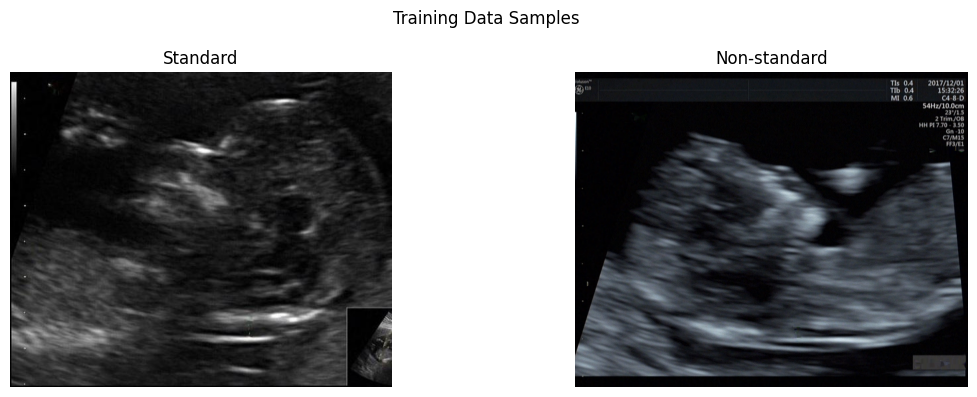

In [ ]:
display_samples(train_data, "Training Data Samples", classes)

In [ ]:
def crop_img(img):

    # Focusing on the extreme points on the image and crops the rectangular out of them using OpenCV
    if img is None:
        return None
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (3, 3), 0)

    # Performing thresholding, then erosion and dilation
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Finding contours using OpenCV
    contours, _ = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    c = max(contours, key=cv2.contourArea)

    # Finding the extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])

    # Cropping the image
    new_img = img[extTop[1]:extBot[1], extLeft[0]:extRight[0]].copy()
    return new_img

def resize_img(img, size=(256, 256)):
    return cv2.resize(img, size)

In [ ]:
# Defining denoising functions
def bilateral_filter(image):
    # Applying Bilateral Filtering
    return cv2.bilateralFilter(image, d=9, sigmaColor=75, sigmaSpace=75)

def non_local_means_denoising(image):
    # Applying Non-Local Means Denoising
    return cv2.fastNlMeansDenoisingColored(image, None, h=10, hColor=10, templateWindowSize=7)

In [ ]:
def preprocess_image(data, classes):
    processed_data = {}
    for class_name in tqdm(classes, desc="Processing image"):
        processed_images = []
        for img_path in data[class_name]:
            img = cv2.imread(img_path)
            cropped_img = crop_img(img)  # Cropping
            resized_img = resize_img(cropped_img)  # Resizing to 256x256
            processed_images.append(resized_img)
        processed_data[class_name] = processed_images
    return processed_data

In [ ]:
def preprocess_data(data, classes, denoising_method=None, save_path=None):
    processed_data = {}
    for class_name in tqdm(classes, desc="Processing dataset"):

        # Creating save directory if save_path is provided
        if save_path is not None:
            class_save_dir = os.path.join(save_path, class_name)
            os.makedirs(class_save_dir, exist_ok=True)

        processed_images = []
        for img in data[class_name]:
            denoised_img = denoising_method(img)  # Conducting the denoising method
            processed_images.append(denoised_img)

            # Saving final preprocessed image
            if save_path is not None:
                img_name = os.path.basename(img_path)
                save_file_path = os.path.join(class_save_dir, img_name)
                cv2.imwrite(save_file_path, processed_img)

        processed_data[class_name] = processed_images
    return processed_data

In [ ]:
def visualize_datasets(data_dict, classes, plot_title="", num_samples=4, save_path=None):
    num_methods = len(data_dict)
    fig_height = 4 + (2 * (num_methods - 1))  # Adjusting figure height dynamically
    plt.figure(figsize=(12, fig_height))

    for i, (method_name, dataset) in enumerate(data_dict.items()):
        for j, class_name in enumerate(classes[:num_samples]):
            img_data = dataset[class_name][0]  # Getting the first image of each class

            # Checking if img_data is a file path or preloaded image
            if isinstance(img_data, str):  # It's a file path
                img = cv2.imread(img_data)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            else:  # It would be a preloaded image data (numpy array)
                img = cv2.cvtColor(img_data, cv2.COLOR_BGR2RGB)

            # Computing subplot index
            subplot_idx = j + 1 + (i * num_samples)
            plt.subplot(num_methods, num_samples, subplot_idx)
            plt.imshow(img)
            plt.title(f"{method_name} - {class_name}")
            plt.axis("off")

    if plot_title:
        plt.suptitle(plot_title, fontsize=16)
    plt.tight_layout()

    # Saving the plot if a path is provided
    if save_path:
        # Ensure the directory exists
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path)
        print(f"Plot saved to {save_path}")

    # Displaying the plot
    plt.show()

In [ ]:
# Preprocessing cropped and resized images
train_cropped_resized = preprocess_image(train_data, classes)

Processing image: 100%|██████████| 2/2 [00:05<00:00,  2.69s/it]


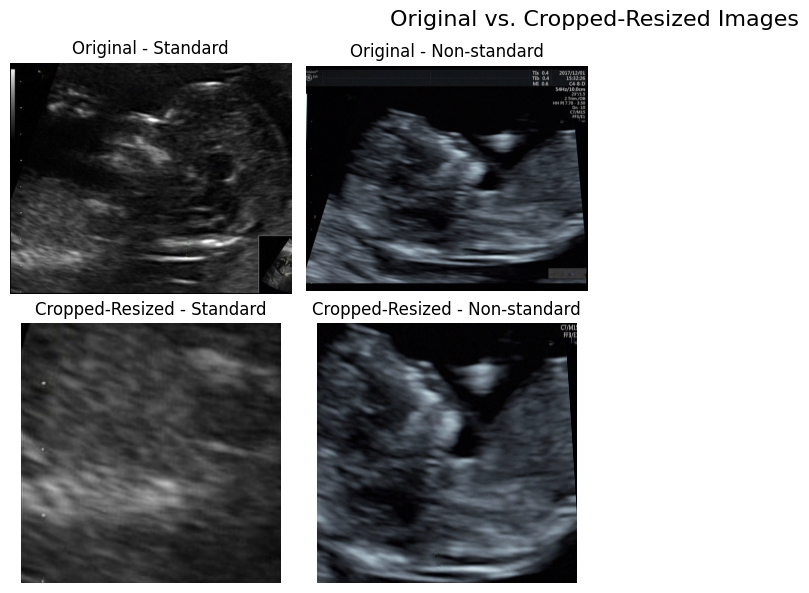

In [ ]:
# Visualizing original vs. cropped-resized images
data_to_visualize = {
    "Original": train_data,
    "Cropped-Resized": train_cropped_resized,
}
visualize_datasets(data_to_visualize, classes, plot_title="Original vs. Cropped-Resized Images")

In [ ]:
# Preprocessing with Bilateral Filtering
train_bilateral = preprocess_data(train_cropped_resized, classes, bilateral_filter)

Processing dataset: 100%|██████████| 2/2 [00:04<00:00,  2.02s/it]


In [ ]:
# Preprocessing with Non-Local Means Denoising
train_non_local_means = preprocess_data(train_cropped_resized, classes, non_local_means_denoising)

Processing dataset: 100%|██████████| 2/2 [01:16<00:00, 38.29s/it]


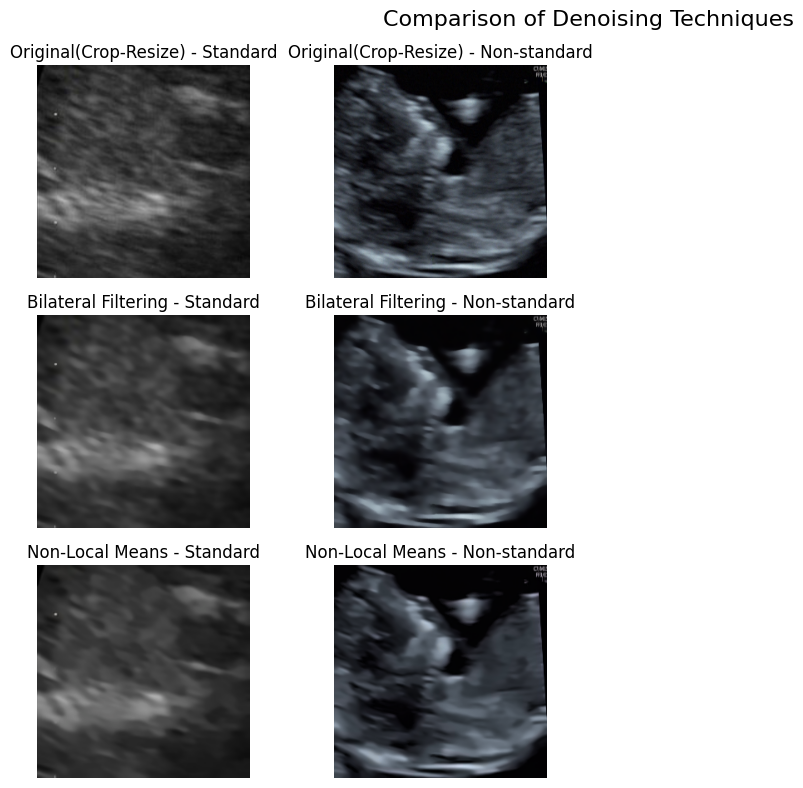

In [ ]:
# Visualizing denoising results
data_to_visualize = {
    "Original(Crop-Resize)": train_cropped_resized,
    "Bilateral Filtering": train_bilateral,
    "Non-Local Means": train_non_local_means,
}
visualize_datasets(data_to_visualize, classes, plot_title="Comparison of Denoising Techniques")

In [ ]:
# Class distribution
def check_class_distribution(data, classes, title="Class Distribution"):
    counts = {class_name: len(data[class_name]) for class_name in classes}
    plt.bar(counts.keys(), counts.values())
    plt.title(title)
    plt.xlabel("Class")
    plt.ylabel("Number of Images")
    plt.show()

def plot_pixel_intensity(data, classes, num_samples=4):
    """
    Plots pixel intensity histograms for images in each class.
    """
    import pandas as pd
    plt.figure(figsize=(12, 6))
    for i, class_name in enumerate(classes[:num_samples]):
        img = data[class_name][0]
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Clean data by replacing inf and dropping NaN
        clean_data = gray.ravel()
        clean_data = pd.Series(clean_data).replace([np.inf, -np.inf], np.nan).dropna()

        # Convert back to NumPy array to avoid internal handling issues
        clean_data = np.array(clean_data)

        plt.subplot(1, len(classes), i + 1)
        sns.histplot(clean_data, bins=256, color='blue', kde=True)
        plt.title(f"Pixel Intensity - {class_name}")
        plt.xlabel("Intensity")
        plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

Checking class distribution...


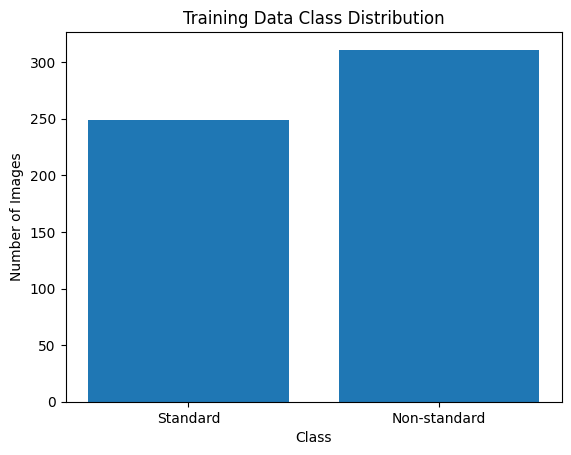

In [ ]:
print("Checking class distribution...")
check_class_distribution(train_cropped_resized, classes, title="Training Data Class Distribution")

Checking class distribution...


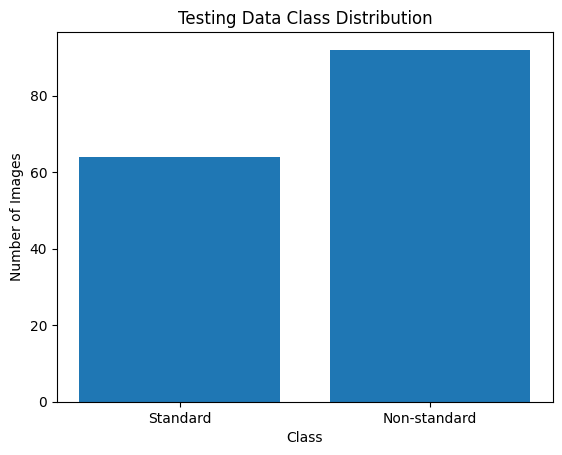

In [ ]:
print("Checking class distribution...")
check_class_distribution(test_data, classes, title="Testing Data Class Distribution")

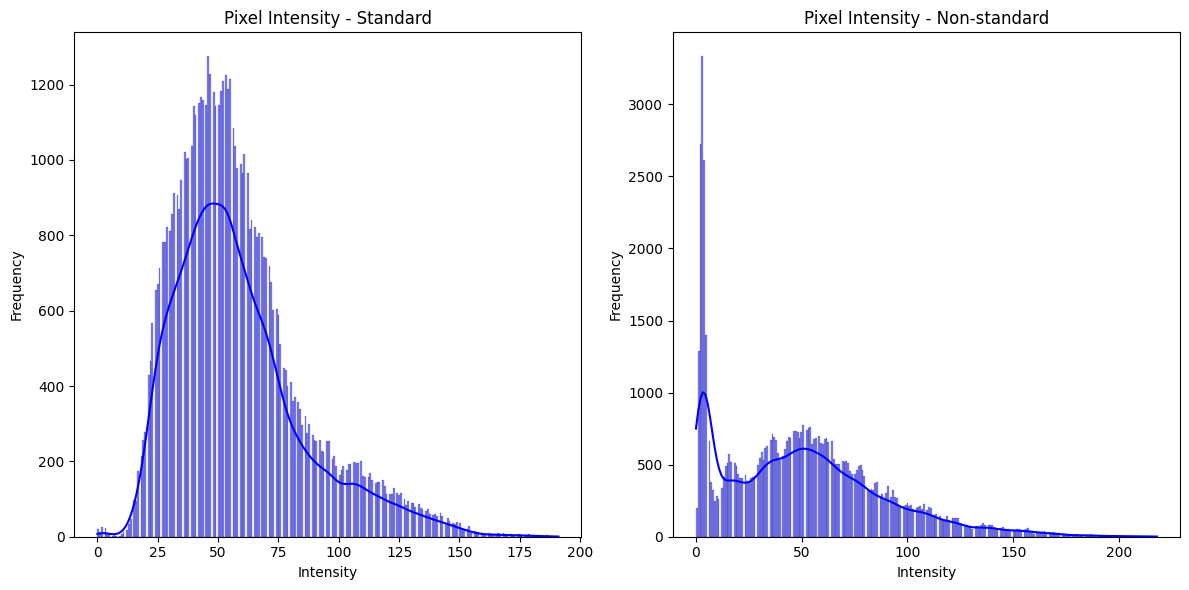

In [ ]:
plot_pixel_intensity(train_cropped_resized, classes)

In [ ]:
def threshold_segmentation(image, threshold=100, use_otsu=False):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    if use_otsu:
        _, binary_mask = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    else:
        _, binary_mask = cv2.threshold(gray, threshold, 255, cv2.THRESH_BINARY)

    return binary_mask

In [ ]:
def apply_threshold_segmentation(data, classes, threshold=100, use_otsu=False):
    segmented_data = {}
    for class_name in classes:
        segmented_images = []
        for img in data[class_name]:
            binary_mask = threshold_segmentation(img, threshold, use_otsu)
            segmented_images.append(binary_mask)
        segmented_data[class_name] = segmented_images
    return segmented_data

In [ ]:
# Applying threshold-based segmentation (denoised data)
threshold_segmented = apply_threshold_segmentation(train_non_local_means, classes, threshold=100, use_otsu=False)

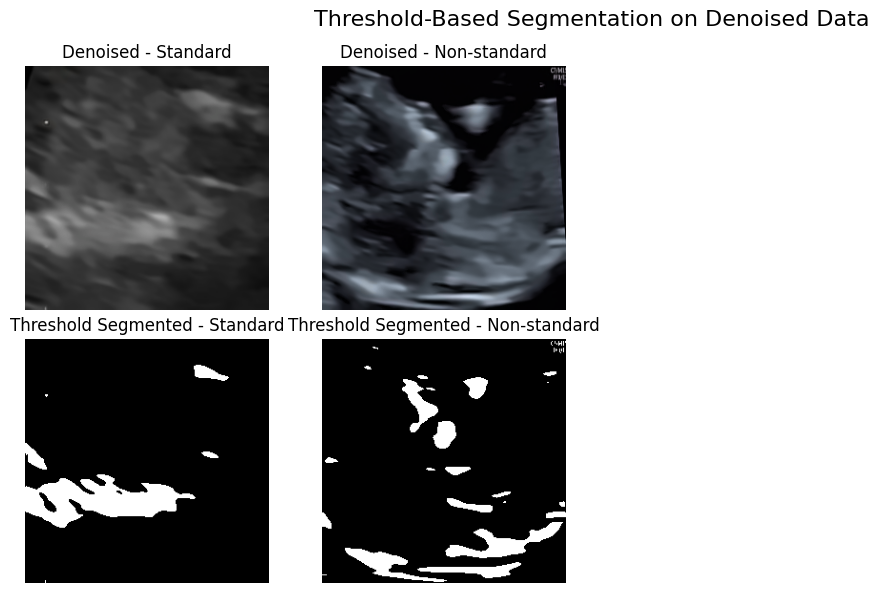

In [ ]:
# Visualizing original (denoised) vs segmented results
data_to_visualize = {
    "Denoised": train_non_local_means,
    "Threshold Segmented": threshold_segmented,
}
visualize_datasets(data_to_visualize, classes, plot_title="Threshold-Based Segmentation on Denoised Data")

In [ ]:
def refine_segmentation(binary_mask, operation="closing", kernel_size=5):
    # Defining the structuring element (kernel)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_size, kernel_size))

    if operation == "erosion":
        refined_mask = cv2.erode(binary_mask, kernel, iterations=1)
    elif operation == "dilation":
        refined_mask = cv2.dilate(binary_mask, kernel, iterations=1)
    elif operation == "opening":
        refined_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_OPEN, kernel)
    elif operation == "closing":
        refined_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_CLOSE, kernel)
    else:
        raise ValueError("Invalid operation. Choose from 'erosion', 'dilation', 'opening', or 'closing'.")

    return refined_mask

def refine_dataset_segmentation(segmented_data, classes, operation="closing", kernel_size=5):
    refined_data = {}
    for class_name in classes:
        refined_images = []
        for binary_mask in segmented_data[class_name]:
            refined_mask = refine_segmentation(binary_mask, operation=operation, kernel_size=kernel_size)
            refined_images.append(refined_mask)
        refined_data[class_name] = refined_images
    return refined_data

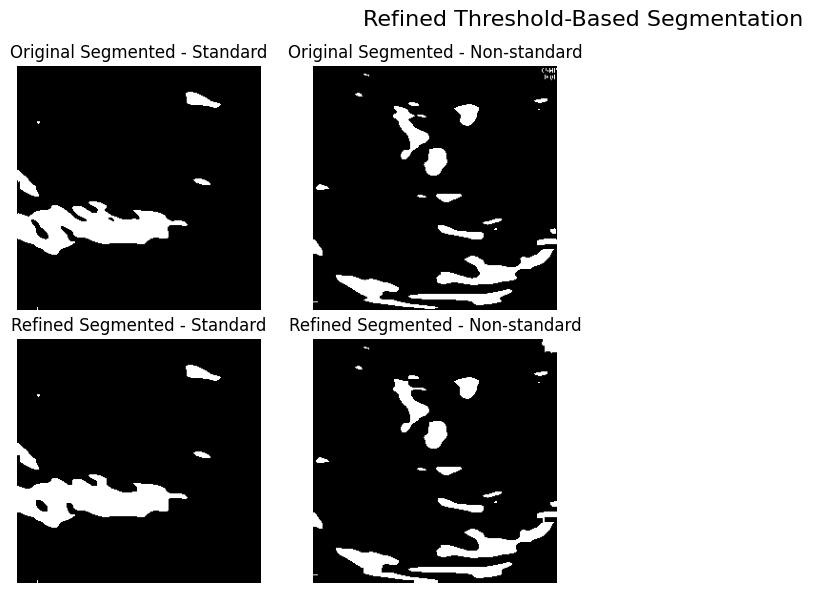

In [ ]:
# Refining segmentation masks (using closing as default)
refined_threshold_segmented = refine_dataset_segmentation(threshold_segmented, classes, operation="closing", kernel_size=5)

# Displaying original vs. refined segmentation
data_to_visualize = {
    "Original Segmented": threshold_segmented,
    "Refined Segmented": refined_threshold_segmented,
}
visualize_datasets(data_to_visualize, classes, plot_title="Refined Threshold-Based Segmentation")

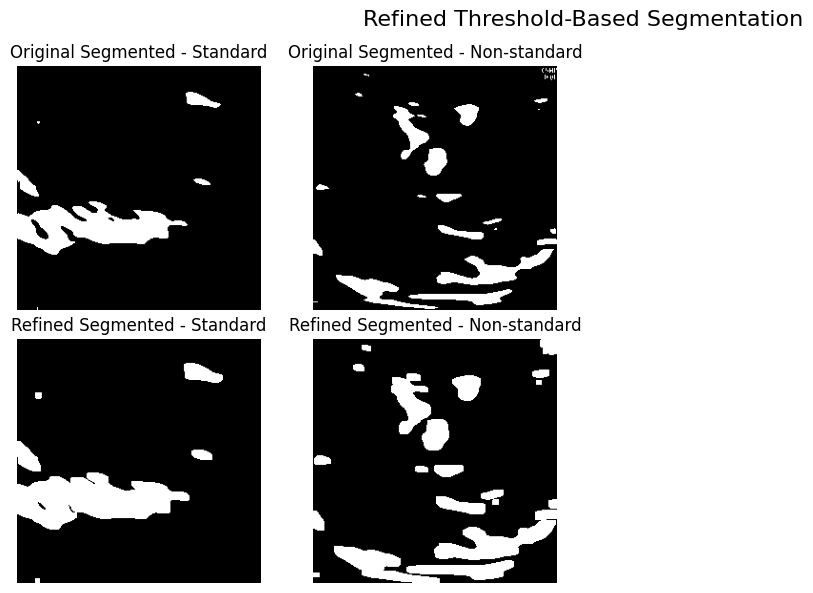

In [ ]:
# Refining segmentation masks (using closing as default)
refined_threshold_segmented = refine_dataset_segmentation(threshold_segmented, classes, operation="dilation", kernel_size=5)

# Visualizing original vs. refined segmentation
data_to_visualize = {
    "Original Segmented": threshold_segmented,
    "Refined Segmented": refined_threshold_segmented,
}
visualize_datasets(data_to_visualize, classes, plot_title="Refined Threshold-Based Segmentation")

In [ ]:
def edge_based_segmentation(image, low_threshold=50, high_threshold=150):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, low_threshold, high_threshold)
    return edges

In [ ]:
def apply_edge_segmentation(data, classes, low_threshold=50, high_threshold=150):
    edge_segmented_data = {}
    for class_name in classes:
        edge_images = []
        for img in data[class_name]:
            edges = edge_based_segmentation(img, low_threshold, high_threshold)
            edge_images.append(edges)
        edge_segmented_data[class_name] = edge_images
    return edge_segmented_data

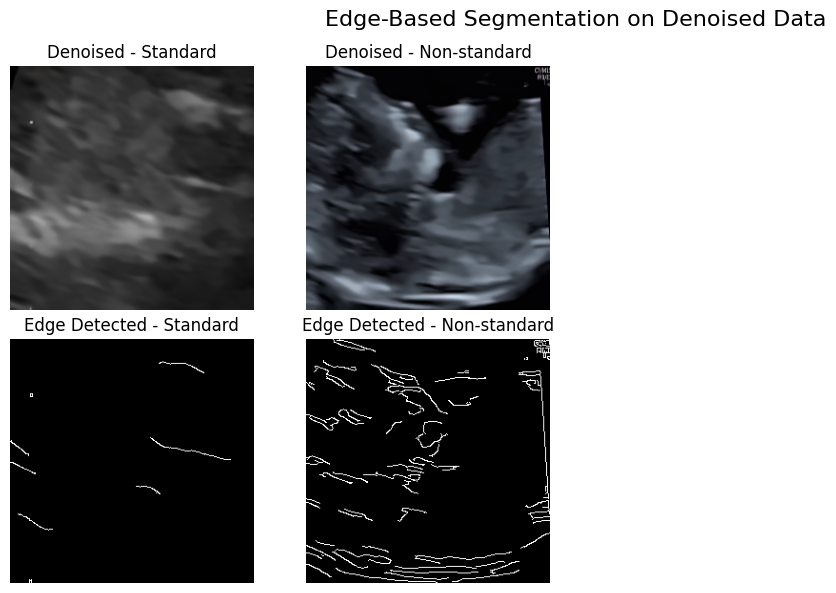

In [ ]:
# Implementing edge detection to the denoised data
edge_segmented = apply_edge_segmentation(train_non_local_means, classes, low_threshold=50, high_threshold=150)

# Visualizing original (denoised) vs edge-detected results
data_to_visualize = {
    "Denoised": train_non_local_means,
    "Edge Detected": edge_segmented,
}
visualize_datasets(data_to_visualize, classes, plot_title="Edge-Based Segmentation on Denoised Data")

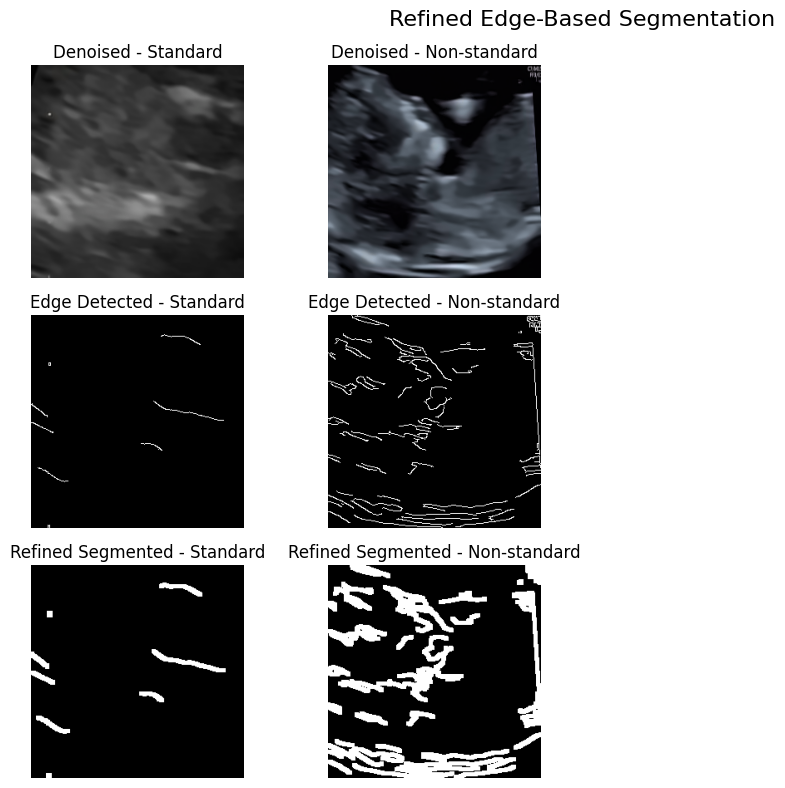

In [ ]:
# Refining segmentation masks
refined_edge_segmented = refine_dataset_segmentation(edge_segmented, classes, operation="dilation", kernel_size=5)

# Visualizing original vs. refined segmentation
data_to_visualize = {
    "Denoised": train_non_local_means,
    "Edge Detected": edge_segmented,
    "Refined Segmented": refined_edge_segmented,
}
visualize_datasets(data_to_visualize, classes, plot_title="Refined Edge-Based Segmentation")

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [ ]:
# Converting preprocessed dataset into NumPy arrays
def prepare_dataset(data_dict, classes):
    X, y = [], []
    for idx, class_name in enumerate(classes):
        for img in data_dict[class_name]:
            X.append(img)
            y.append(idx)  # Label is the index of the class
    return np.array(X), np.array(y)

In [ ]:
def build_cnn(input_shape=(256, 256, 3), num_classes=2):
    model = Sequential([
        Input(shape=input_shape),
        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')  # Output layer
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
# Instantiating the CNN model
cnn_model = build_cnn()

In [ ]:
cnn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 115200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    14,745,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,839,234 (56.61 MB)

 Trainable params: 14,839,234 (56.61 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Preparing training data
X_train, y_train = prepare_dataset(train_non_local_means, classes)

In [ ]:
# Normalizing the images (scale to range [0, 1])
X_train = X_train / 255.0

# Converting labels to categorical format
y_train = to_categorical(y_train, num_classes=len(classes))

# Splitting into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [ ]:
# Training CNN on preprocessed dataset
cnn_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=8,
    batch_size=16
)

Epoch 1/8
28/28 ━━━━━━━━━━━━━━━━━━━━ 15s 476ms/step - accuracy: 0.5195 - loss: 0.9563 - val_accuracy: 0.5804 - val_loss: 0.6587
Epoch 2/8
28/28 ━━━━━━━━━━━━━━━━━━━━ 13s 457ms/step - accuracy: 0.7152 - loss: 0.5558 - val_accuracy: 0.8304 - val_loss: 0.4449
Epoch 3/8
28/28 ━━━━━━━━━━━━━━━━━━━━ 20s 448ms/step - accuracy: 0.8489 - loss: 0.3735 - val_accuracy: 0.7857 - val_loss: 0.4866
Epoch 4/8
28/28 ━━━━━━━━━━━━━━━━━━━━ 13s 447ms/step - accuracy: 0.8546 - loss: 0.3388 - val_accuracy: 0.8036 - val_loss: 0.5073
Epoch 5/8
28/28 ━━━━━━━━━━━━━━━━━━━━ 12s 445ms/step - accuracy: 0.9274 - loss: 0.1900 - val_accuracy: 0.8125 - val_loss: 0.5076
Epoch 6/8
28/28 ━━━━━━━━━━━━━━━━━━━━ 12s 446ms/step - accuracy: 0.9626 - loss: 0.1200 - val_accuracy: 0.7679 - val_loss: 0.5740
Epoch 7/8
28/28 ━━━━━━━━━━━━━━━━━━━━ 13s 450ms/step - accuracy: 0.9651 - loss: 0.1070 - val_accuracy: 0.7500 - val_loss: 0.8003
Epoch 8/8
28/28 ━━━━━━━━━━━━━━━━━━━━ 13s 466ms/step - accuracy: 0.9877 - loss: 0.0552 - val_accuracy: 0.

In [ ]:
def get_last_conv_layer_name(model):
    for layer in reversed(model.layers):
        if isinstance(layer, tf.keras.layers.Conv2D):
            return layer.name
    raise ValueError("No convolutional layer found in the model.")

def grad_cam(model, image, class_index, last_conv_layer_name):

    # Retrieving the last convolutional layer
    last_conv_layer = model.get_layer(last_conv_layer_name)

    # Creating a sub-model for Grad-CAM
    grad_model = tf.keras.models.Model(
        inputs=model.inputs,
        outputs=[last_conv_layer.output, model.outputs[0]]
    )

    # Computing gradients
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(np.expand_dims(image, axis=0))
        loss = predictions[:, class_index]
    grads = tape.gradient(loss, conv_outputs)

    # Computing channel-wise mean
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]

    # Generating heatmap
    heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1)
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap

In [ ]:
def overlay_gradcam(image, heatmap, alpha=0.4):
    heatmap = cv2.resize(heatmap, (image.shape[1], image.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    overlayed_image = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)
    return overlayed_image

In [ ]:
# Preprocessing Testing data (resize, crop, and denoise)
test_cropped_resized = preprocess_image(test_data, classes)  # Applying cropping and resizing
test_non_local_means = preprocess_data(test_cropped_resized, classes, non_local_means_denoising)  # Applying denoising

Processing dataset: 100%|██████████| 2/2 [00:21<00:00, 10.71s/it]


In [ ]:
# Converting preprocessed Testing data into NumPy arrays
X_test, y_test = prepare_dataset(test_non_local_means, classes)

# Normalizing the Testing images (scale to range [0, 1])
X_test = X_test / 255.0

# Converting labels to categorical format
y_test = to_categorical(y_test, num_classes=len(classes))

In [ ]:
# Evaluating the model on Testing data
test_loss, test_accuracy = cnn_model.evaluate(X_test, y_test, batch_size=32)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 221ms/step - accuracy: 0.4298 - loss: 3.8116
Test Loss: 2.6542296409606934
Test Accuracy: 0.557692289352417


In [ ]:
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

In [ ]:
# Flattening input
X_flat = X_train.reshape(X_train.shape[0], -1)
X_val_flat = X_val.reshape(X_val.shape[0], -1)
y_train_int = np.argmax(y_train, axis=1)
y_val_int = np.argmax(y_val, axis=1)

In [ ]:
# Base classifiers
svm_clf = SVC(kernel='rbf', probability=True)
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Ensembleing RF and SVM with soft voting
voting_clf = VotingClassifier(
    estimators=[('svm', svm_clf), ('rf', rf_clf)],
    voting='soft'
)


In [ ]:
# Training the ensembled model
voting_clf.fit(X_flat, y_train_int)

VotingClassifier(estimators=[('svm', SVC(probability=True)),
                             ('rf', RandomForestClassifier(random_state=42))],
                 voting='soft')

In [ ]:
# Predicting and evaluation
y_pred_ensemble = voting_clf.predict(X_val_flat)
print("Ensemble (SVM + RF) Classification Report:")
print(classification_report(y_val_int, y_pred_ensemble, target_names=classes))

Ensemble (SVM + RF) Classification Report:
              precision    recall  f1-score   support

    Standard       0.83      0.61      0.71        57
Non-standard       0.69      0.87      0.77        55

    accuracy                           0.74       112
   macro avg       0.76      0.74      0.74       112
weighted avg       0.76      0.74      0.74       112



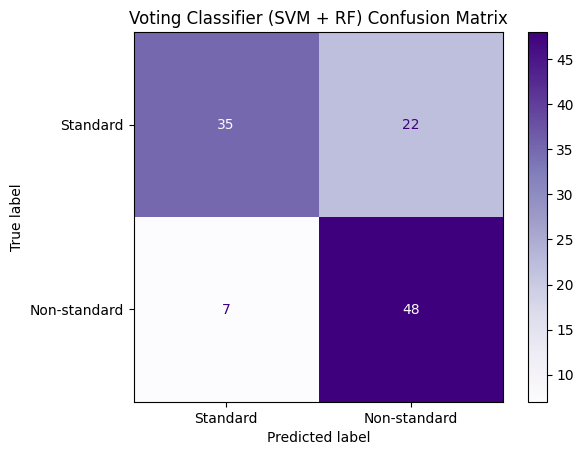

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_val_int, y_pred_ensemble)
ConfusionMatrixDisplay(cm, display_labels=classes).plot(cmap='Purples')
plt.title("Voting Classifier (SVM + RF) Confusion Matrix")
plt.show()

In [ ]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(voting_clf, X_flat, y_train_int, cv=5)
print("Cross-validation scores:", scores)
print("Average CV Accuracy:", np.mean(scores))

Cross-validation scores: [0.71111111 0.77777778 0.66666667 0.68539326 0.76404494]
Average CV Accuracy: 0.7209987515605494


In [ ]:
# Applying SMOTE Before Train-Test Split
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_flat, y_train_int)

from collections import Counter
print("Class distribution after SMOTE:", Counter(y_resampled))

Class distribution after SMOTE: Counter({np.int64(1): 256, np.int64(0): 256})


In [ ]:
from sklearn.model_selection import train_test_split

X_train_sm, X_val_sm, y_train_sm, y_val_sm = train_test_split(
    X_resampled, y_resampled, test_size=0.2, stratify=y_resampled, random_state=42
)

In [ ]:
voting_model_sm = VotingClassifier(
    estimators=[('svm', SVC(kernel='rbf', probability=True)),
                ('rf', RandomForestClassifier(n_estimators=100, random_state=42))],
    voting='soft'
)

voting_model_sm.fit(X_train_sm, y_train_sm)

VotingClassifier(estimators=[('svm', SVC(probability=True)),
                             ('rf', RandomForestClassifier(random_state=42))],
                 voting='soft')

Classification Report (SMOTE):
              precision    recall  f1-score   support

    Standard       0.75      0.75      0.75        52
Non-standard       0.75      0.75      0.75        51

    accuracy                           0.75       103
   macro avg       0.75      0.75      0.75       103
weighted avg       0.75      0.75      0.75       103



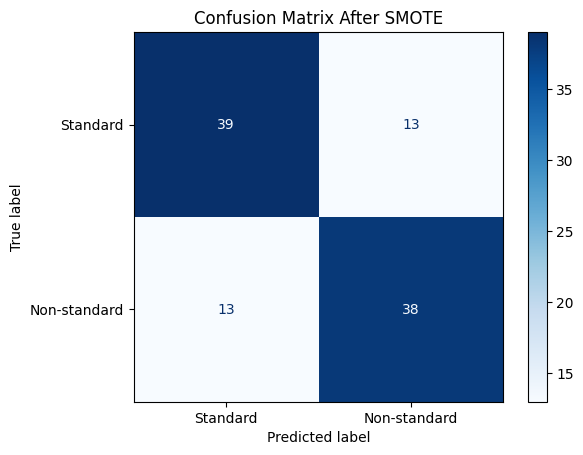

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

y_pred_sm = voting_model_sm.predict(X_val_sm)
print("Classification Report (SMOTE):")
print(classification_report(y_val_sm, y_pred_sm, target_names=classes))

cm = confusion_matrix(y_val_sm, y_pred_sm)
ConfusionMatrixDisplay(cm, display_labels=classes).plot(cmap='Blues')
plt.title("Confusion Matrix After SMOTE")
plt.show()

In [ ]:
from collections import Counter

class_counts = Counter(np.argmax(y_train, axis=1))
print("Original class distribution:", class_counts)

Original class distribution: Counter({np.int64(1): 256, np.int64(0): 192})


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

datagen = ImageDataGenerator(
    rotation_range=15,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

In [ ]:
# Manually Oversampling Underrepresented Classes
augmented_images = []
augmented_labels = []

# Setting target count
target_count = max(class_counts.values())

for class_idx in range(len(classes)):
    # Getting images from this class
    class_images = X_train[np.argmax(y_train, axis=1) == class_idx]
    class_labels = y_train[np.argmax(y_train, axis=1) == class_idx]

    n_to_generate = target_count - len(class_images)

    if n_to_generate > 0:
        # Using generator to create new images
        gen = datagen.flow(class_images, class_labels, batch_size=1)
        for _ in range(n_to_generate):
            img, label = next(gen)
            augmented_images.append(img[0])
            augmented_labels.append(label[0])

# Combining original + synthetic
X_train_augmented = np.concatenate((X_train, np.array(augmented_images)), axis=0)
y_train_augmented = np.concatenate((y_train, np.array(augmented_labels)), axis=0)

In [ ]:
from sklearn.utils import shuffle

X_train_augmented, y_train_augmented = shuffle(X_train_augmented, y_train_augmented, random_state=42)

# Training the CNN model
cnn_model.fit(
    X_train_augmented, y_train_augmented,
    validation_data=(X_val, y_val),
    epochs=8,
    batch_size=16
)

Epoch 1/8
32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 444ms/step - accuracy: 0.9329 - loss: 0.2324 - val_accuracy: 0.7054 - val_loss: 0.7295
Epoch 2/8
32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 441ms/step - accuracy: 0.9675 - loss: 0.1251 - val_accuracy: 0.7411 - val_loss: 0.9852
Epoch 3/8
32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 434ms/step - accuracy: 0.9774 - loss: 0.0702 - val_accuracy: 0.7946 - val_loss: 0.8010
Epoch 4/8
32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 434ms/step - accuracy: 0.9891 - loss: 0.0586 - val_accuracy: 0.7857 - val_loss: 1.1047
Epoch 5/8
32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 431ms/step - accuracy: 0.9896 - loss: 0.0255 - val_accuracy: 0.7946 - val_loss: 1.3141
Epoch 6/8
32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 436ms/step - accuracy: 0.9921 - loss: 0.0221 - val_accuracy: 0.8036 - val_loss: 1.4154
Epoch 7/8
32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 429ms/step - accuracy: 0.9904 - loss: 0.0245 - val_accuracy: 0.7946 - val_loss: 1.3925
Epoch 8/8
32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 432ms/step - accuracy: 0.9942 - loss: 0.0291 - val_accuracy: 0.

In [ ]:
# Preprocessing Testing data (resize, crop, and denoise)
test_cropped_resized = preprocess_image(test_data, classes)  # Applying cropping and resizing
test_non_local_means = preprocess_data(test_cropped_resized, classes, non_local_means_denoising)  # Applying denoising

Processing dataset: 100%|██████████| 2/2 [00:21<00:00, 10.66s/it]


In [ ]:
# Converting preprocessed Testing data into NumPy arrays
X_test, y_test = prepare_dataset(test_non_local_means, classes)

# Normalizing the Testing images
X_test = X_test / 255.0

# Converting labels to categorical format
y_test = to_categorical(y_test, num_classes=len(classes))

In [ ]:
# Evaluating the model on Testing data
test_loss, test_accuracy = cnn_model.evaluate(X_test, y_test, batch_size=32)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 212ms/step - accuracy: 0.5492 - loss: 3.2822
Test Loss: 3.4985876083374023
Test Accuracy: 0.5448718070983887


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(1, 256, 256, 3))
  warnings.warn(msg)


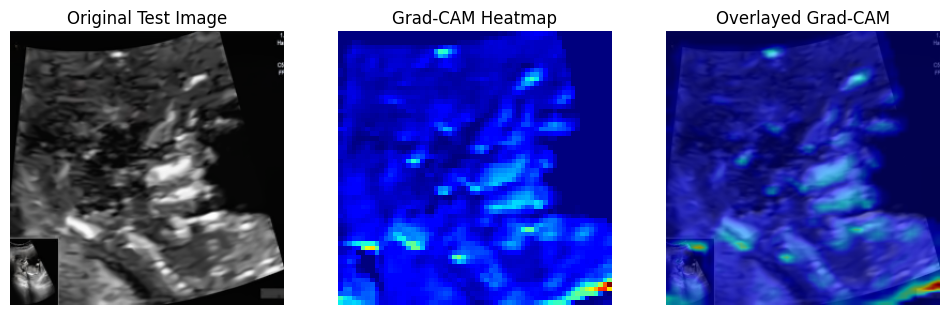

In [ ]:
# Getting a sample image from the Testing dataset
sample_test_image = test_non_local_means["Non-standard"][0]
sample_test_image_preprocessed = sample_test_image / 255.0

# Predicting class
predictions = cnn_model.predict(np.expand_dims(sample_test_image_preprocessed, axis=0))
predicted_class = np.argmax(predictions)

# Generating Grad-CAM heatmap
heatmap = grad_cam(cnn_model, sample_test_image_preprocessed, predicted_class, last_conv_layer_name="conv2d_2")

# Overlaying Grad-CAM heatmap on the original image
overlayed_image = overlay_gradcam(sample_test_image, heatmap)

# Visualizing results
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.title("Original Test Image")
plt.imshow(cv2.cvtColor(sample_test_image, cv2.COLOR_BGR2RGB))
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title("Grad-CAM Heatmap")
plt.imshow(heatmap, cmap="jet")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title("Overlayed Grad-CAM")
plt.imshow(cv2.cvtColor(overlayed_image, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

In [ ]:
# Applying Threshold, Edge and GradCam segmentation methods on Testing data

In [ ]:
# Applying threshold-based segmentation (test denoised data)
test_threshold_segmented = apply_threshold_segmentation(test_non_local_means, classes, threshold=100, use_otsu=False)

In [ ]:
# Applying edge-based segmentation (test denoised data)
test_edge_segmented = apply_edge_segmentation(test_non_local_means, classes, low_threshold=50, high_threshold=150)

In [ ]:
# Grad-CAM results for test images
def apply_cnn_gradcam_segmentation(test_non_local_means, classes):
    test_gradcam_heatmap = {}
    test_gradcam_overlay = {}

    for class_name in classes:
        if class_name in test_non_local_means:
            # Getting the first image from the class
            denoised_image = test_non_local_means[class_name][0]
            denoised_image_preprocessed = denoised_image / 255.0

            # Predicting class
            predictions = cnn_model.predict(np.expand_dims(denoised_image_preprocessed, axis=0))
            predicted_class = np.argmax(predictions)

            # Generating Grad-CAM heatmap and overlay
            gradcam_heatmap = grad_cam(cnn_model, denoised_image_preprocessed, predicted_class, last_conv_layer_name="conv2d_2")
            gradcam_overlay = overlay_gradcam(denoised_image, gradcam_heatmap)

            # Storing results
            test_gradcam_heatmap[class_name] = [gradcam_heatmap]
            test_gradcam_overlay[class_name] = [gradcam_overlay]

    return test_gradcam_heatmap, test_gradcam_overlay

In [ ]:
test_gradcam_heatmap, test_gradcam_overlay = apply_cnn_gradcam_segmentation(test_non_local_means, classes)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


In [ ]:
def visualize_segmentation_comparison(originals, threshold_masks, edge_masks, gradcam_overlays, classes, num_samples=4):
    for class_name in classes[:num_samples]:
        orig = originals[class_name][0]
        thresh = threshold_masks[class_name][0]
        edge = edge_masks[class_name][0]
        gradcam = gradcam_overlays[class_name][0]

        plt.figure(figsize=(12, 4))
        plt.suptitle(f"Segmentation Comparisons for Class: {class_name}", fontsize=14)

        plt.subplot(1, 4, 1)
        plt.title("Original")
        plt.imshow(cv2.cvtColor(orig, cv2.COLOR_BGR2RGB))
        plt.axis("off")

        plt.subplot(1, 4, 2)
        plt.title("Threshold")
        plt.imshow(thresh, cmap='gray')
        plt.axis("off")

        plt.subplot(1, 4, 3)
        plt.title("Edge")
        plt.imshow(edge, cmap='gray')
        plt.axis("off")

        plt.subplot(1, 4, 4)
        plt.title("Grad-CAM")
        plt.imshow(cv2.cvtColor(gradcam, cv2.COLOR_BGR2RGB))
        plt.axis("off")

        plt.tight_layout()
        plt.show()

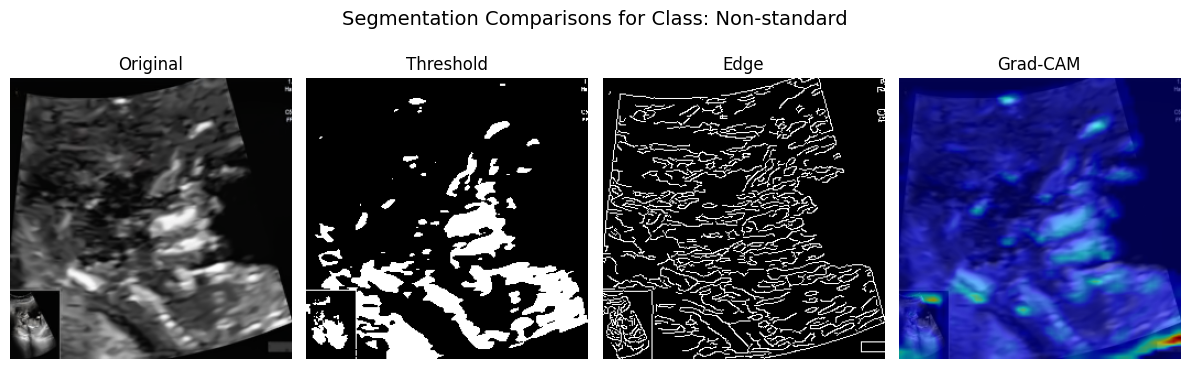

In [ ]:
# Visualizing comparison
visualize_segmentation_comparison(
    originals=test_non_local_means,
    threshold_masks=test_threshold_segmented,
    edge_masks=test_edge_segmented,
    gradcam_overlays=test_gradcam_overlay,
    classes=["Non-standard"],
    num_samples=1
)

In [ ]:
data_dict = {
    "Threshold Segmentation": test_threshold_segmented,
    "Edge Segmentation": test_edge_segmented,
    "Grad-CAM Overlay": test_gradcam_overlay
}

Plot saved to ./segmentation_comparison.png


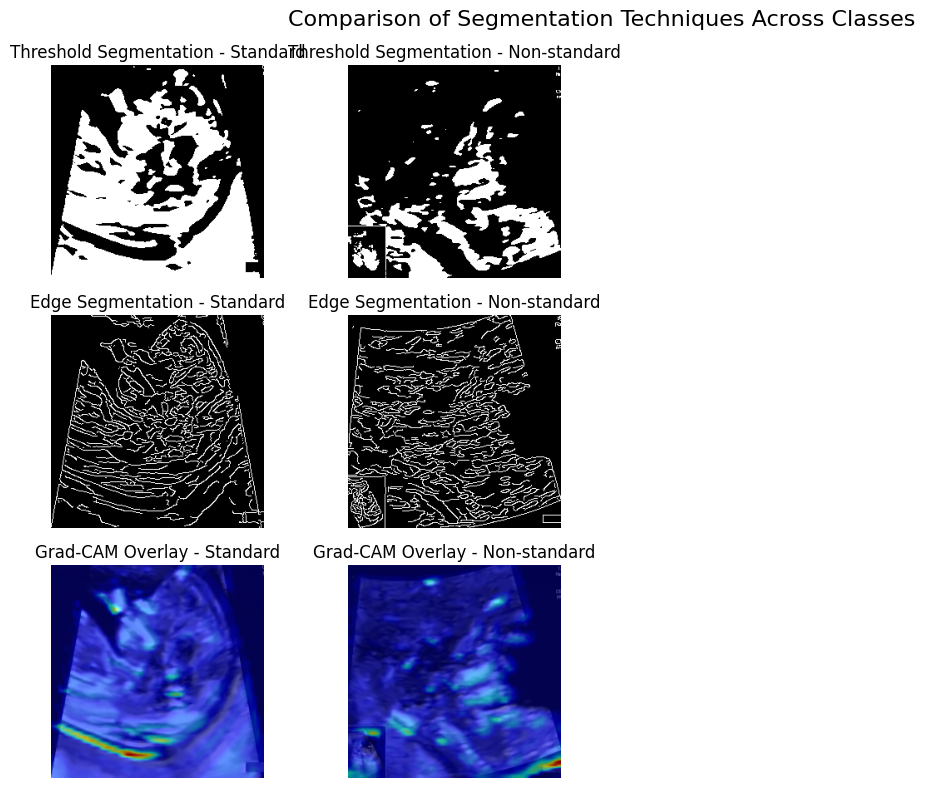

In [ ]:
visualize_datasets(
    data_dict=data_dict,
    classes=classes,
    plot_title="Comparison of Segmentation Techniques Across Classes",
    save_path="./segmentation_comparison.png"
)

In [ ]:
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)


In [ ]:
y_train_int = np.argmax(y_train, axis=1)
y_test_int = np.argmax(y_test, axis=1)


In [ ]:
from sklearn.linear_model import LogisticRegression
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train_flat, y_train_int)
y_pred_lr = lr_model.predict(X_test_flat)
print(classification_report(y_test_int, y_pred_lr))
print(confusion_matrix(y_test_int, y_pred_lr))


              precision    recall  f1-score   support

           0       0.52      0.27      0.35        64
           1       0.62      0.83      0.71        92

    accuracy                           0.60       156
   macro avg       0.57      0.55      0.53       156
weighted avg       0.58      0.60      0.56       156

[[17 47]
 [16 76]]


In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_flat, y_train_int)
y_pred_rf = rf_model.predict(X_test_flat)
print(classification_report(y_test_int, y_pred_rf))
print(confusion_matrix(y_test_int, y_pred_rf))


              precision    recall  f1-score   support

           0       0.44      0.06      0.11        64
           1       0.59      0.95      0.73        92

    accuracy                           0.58       156
   macro avg       0.52      0.50      0.42       156
weighted avg       0.53      0.58      0.47       156

[[ 4 60]
 [ 5 87]]


In [ ]:
from imblearn.over_sampling import SMOTE
from collections import Counter

# Applying SMOTE on flattened training data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_flat, y_train_int)

print("Class distribution after SMOTE:", Counter(y_train_smote))


Class distribution after SMOTE: Counter({np.int64(1): 256, np.int64(0): 256})


In [ ]:
# Retraining Logistic Regression on SMOTE data
lr_model_smote = LogisticRegression(max_iter=1000, random_state=42)
lr_model_smote.fit(X_train_smote, y_train_smote)

# Predicting and evaluation
y_pred_lr_smote = lr_model_smote.predict(X_test_flat)
print("Logistic Regression (with SMOTE) Report")
print(classification_report(y_test_int, y_pred_lr_smote))
print("Confusion Matrix:")
print(confusion_matrix(y_test_int, y_pred_lr_smote))


Logistic Regression (with SMOTE) Report
              precision    recall  f1-score   support

           0       0.51      0.28      0.36        64
           1       0.62      0.82      0.70        92

    accuracy                           0.60       156
   macro avg       0.57      0.55      0.53       156
weighted avg       0.58      0.60      0.56       156

Confusion Matrix:
[[18 46]
 [17 75]]


In [ ]:
# Retraining Random Forest on SMOTE data
rf_model_smote = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model_smote.fit(X_train_smote, y_train_smote)

# Predicting and evaluation
y_pred_rf_smote = rf_model_smote.predict(X_test_flat)
print(" Random Forest (with SMOTE) Report")
print(classification_report(y_test_int, y_pred_rf_smote))
print("Confusion Matrix:")
print(confusion_matrix(y_test_int, y_pred_rf_smote))


 Random Forest (with SMOTE) Report
              precision    recall  f1-score   support

           0       0.18      0.03      0.05        64
           1       0.57      0.90      0.70        92

    accuracy                           0.54       156
   macro avg       0.38      0.47      0.38       156
weighted avg       0.41      0.54      0.43       156

Confusion Matrix:
[[ 2 62]
 [ 9 83]]


In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Standardizing the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_flat)
X_test_scaled = scaler.transform(X_test_flat)

# Applying PCA to diminish dimensionality
pca = PCA(n_components=100, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print("Original shape:", X_train_flat.shape)
print("PCA-transformed shape:", X_train_pca.shape)


Original shape: (448, 196608)
PCA-transformed shape: (448, 100)


In [ ]:
# Applying SMOTE to PCA-transformed data
X_train_pca_smote, y_train_pca_smote = SMOTE(random_state=42).fit_resample(X_train_pca, y_train_int)


In [ ]:
# Logistic Regression on PCA + SMOTE
lr_pca = LogisticRegression(max_iter=1000, random_state=42)
lr_pca.fit(X_train_pca_smote, y_train_pca_smote)
y_pred_lr_pca = lr_pca.predict(X_test_pca)

print(" Logistic Regression (PCA + SMOTE) Report")
print(classification_report(y_test_int, y_pred_lr_pca))
print("Confusion Matrix:")
print(confusion_matrix(y_test_int, y_pred_lr_pca))


 Logistic Regression (PCA + SMOTE) Report
              precision    recall  f1-score   support

           0       0.41      0.22      0.29        64
           1       0.59      0.78      0.67        92

    accuracy                           0.55       156
   macro avg       0.50      0.50      0.48       156
weighted avg       0.52      0.55      0.51       156

Confusion Matrix:
[[14 50]
 [20 72]]


In [ ]:
# Random Forest on PCA + SMOTE
rf_pca = RandomForestClassifier(n_estimators=100, random_state=42)
rf_pca.fit(X_train_pca_smote, y_train_pca_smote)
y_pred_rf_pca = rf_pca.predict(X_test_pca)

print(" Random Forest (PCA + SMOTE) Report")
print(classification_report(y_test_int, y_pred_rf_pca))
print("Confusion Matrix:")
print(confusion_matrix(y_test_int, y_pred_rf_pca))


 Random Forest (PCA + SMOTE) Report
              precision    recall  f1-score   support

           0       0.46      0.09      0.16        64
           1       0.59      0.92      0.72        92

    accuracy                           0.58       156
   macro avg       0.53      0.51      0.44       156
weighted avg       0.54      0.58      0.49       156

Confusion Matrix:
[[ 6 58]
 [ 7 85]]


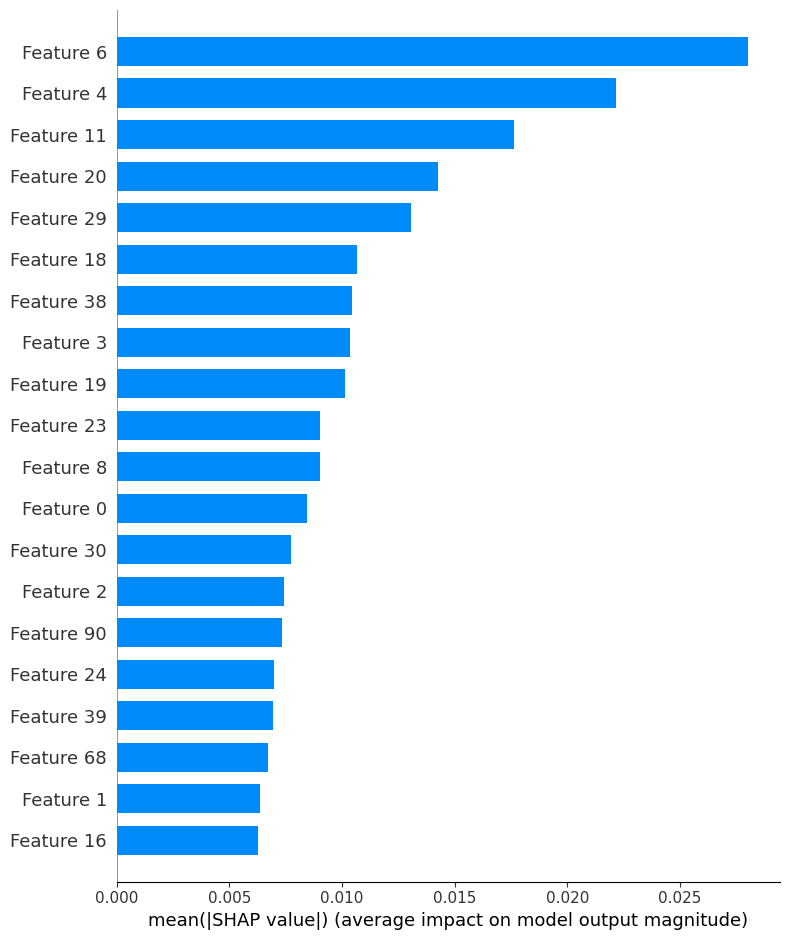

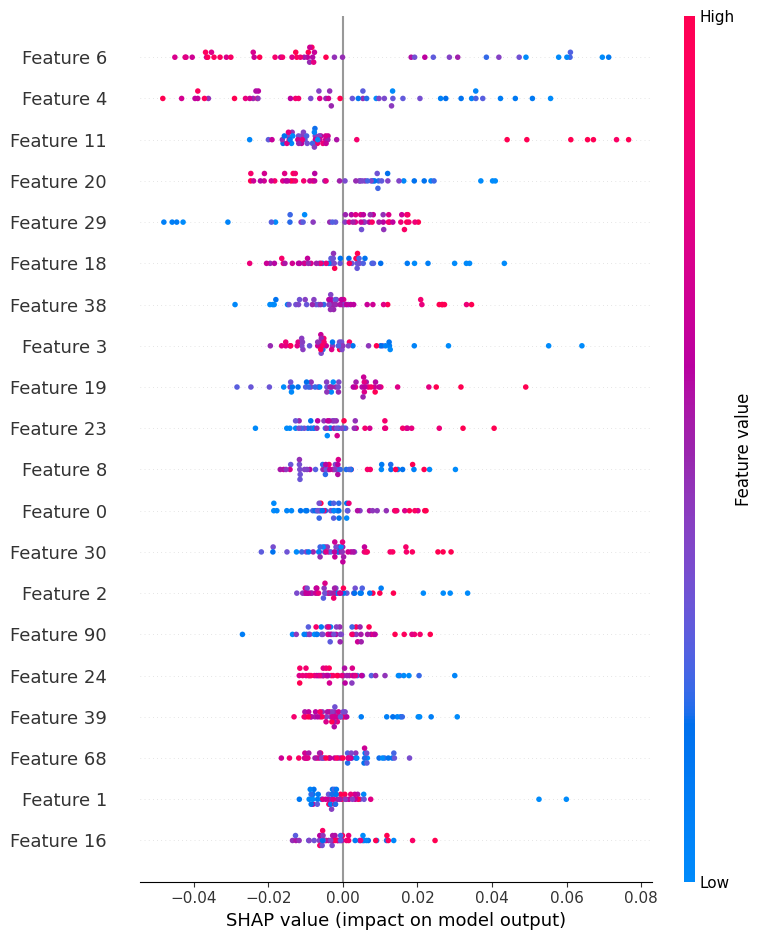

In [ ]:
import shap
import numpy as np
import matplotlib.pyplot as plt

model = rf_pca
X_sample_pca = X_train_pca_smote[:50]

explainer = shap.Explainer(model, X_sample_pca)
shap_values = explainer(X_sample_pca)
shap_matrix = np.array([instance[:, 1] for instance in shap_values.values])

shap.summary_plot(shap_matrix, X_sample_pca, plot_type="bar")
shap.summary_plot(shap_matrix, X_sample_pca)


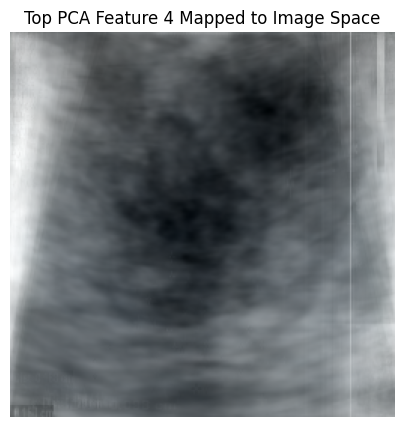

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Extracting the PCA component and reshaping to image
component_vector = pca.components_[4]  # Feature 4
component_img = component_vector.reshape(256, 256, 3)

# Normalizing for display
component_img_norm = (component_img - component_img.min()) / (component_img.max() - component_img.min())

plt.figure(figsize=(5, 5))
plt.imshow(component_img_norm)
plt.title("Top PCA Feature 4 Mapped to Image Space")
plt.axis("off")
plt.show()


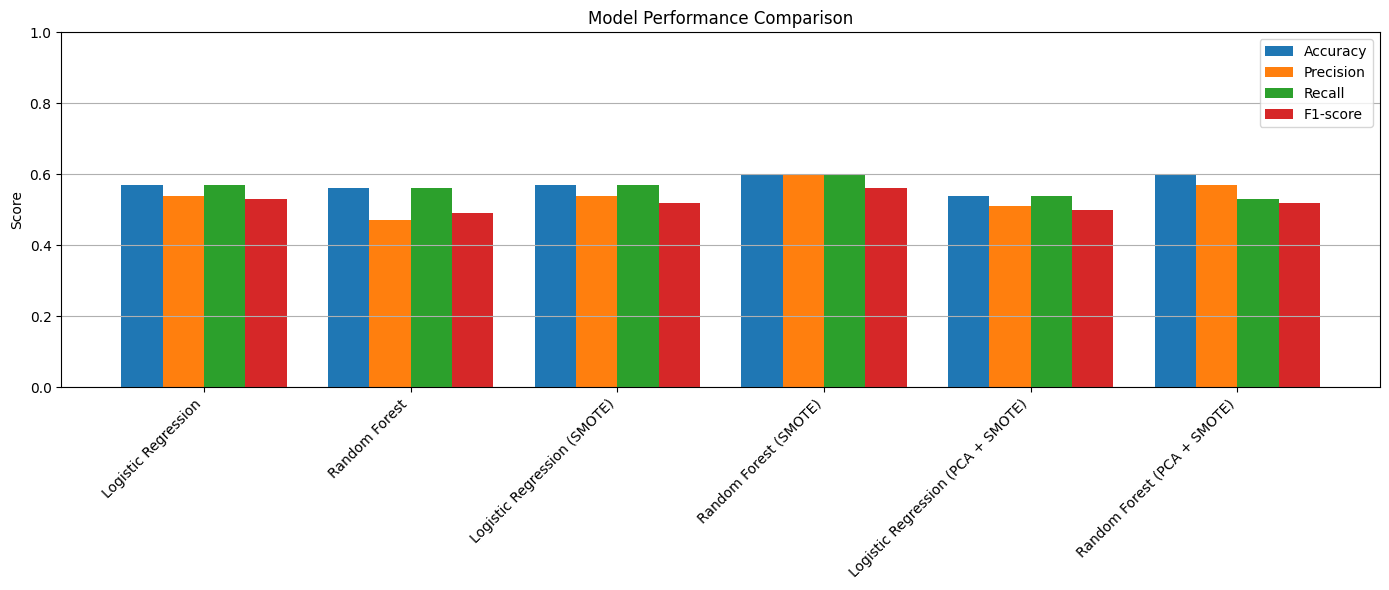

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Defining model names
model_names = [
    "Logistic Regression",
    "Random Forest",
    "Logistic Regression (SMOTE)",
    "Random Forest (SMOTE)",
    "Logistic Regression (PCA + SMOTE)",
    "Random Forest (PCA + SMOTE)"
]

# Accuracy, Precision, Recall, F1-score (manually extracted from previous results)
accuracy =     [0.57, 0.56, 0.57, 0.60, 0.54, 0.60]
precision =    [0.54, 0.47, 0.54, 0.60, 0.51, 0.57]
recall =       [0.57, 0.56, 0.57, 0.60, 0.54, 0.53]
f1_score =     [0.53, 0.49, 0.52, 0.56, 0.50, 0.52]

# Seting up bar width and indices
bar_width = 0.2
x = np.arange(len(model_names))

# Plotting each metric
plt.figure(figsize=(14, 6))
plt.bar(x - 1.5*bar_width, accuracy, bar_width, label='Accuracy')
plt.bar(x - 0.5*bar_width, precision, bar_width, label='Precision')
plt.bar(x + 0.5*bar_width, recall, bar_width, label='Recall')
plt.bar(x + 1.5*bar_width, f1_score, bar_width, label='F1-score')

plt.xticks(x, model_names, rotation=45, ha='right')
plt.ylim(0, 1)
plt.ylabel("Score")
plt.title("Model Performance Comparison")
plt.legend()
plt.tight_layout()
plt.grid(axis='y')

plt.show()


In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=100, random_state=42)
X_train_pca_smote = pca.fit_transform(X_train_smote)
X_test_pca = pca.transform(X_test_flat)


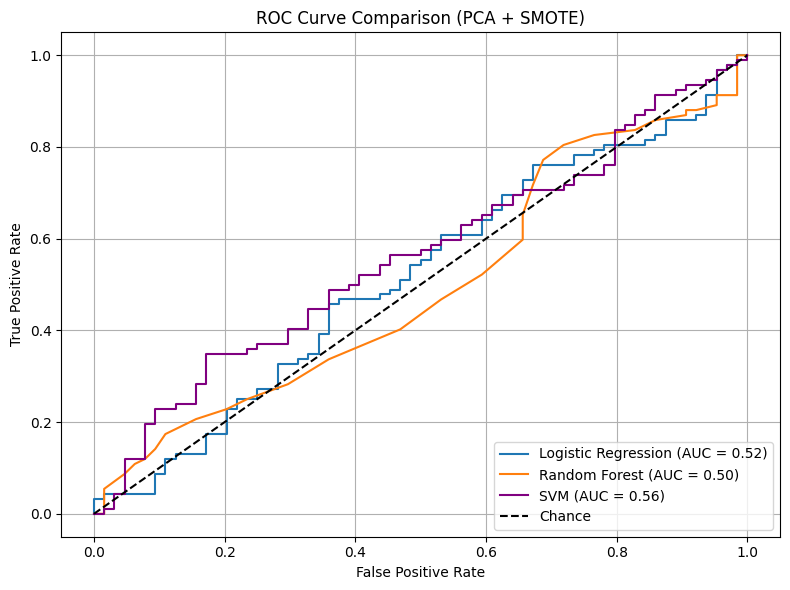

/tmp/ipython-input-94-2734379041.py:62: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([lr_scores, rf_scores, svm_scores], labels=['LogReg', 'RF', 'SVM'])


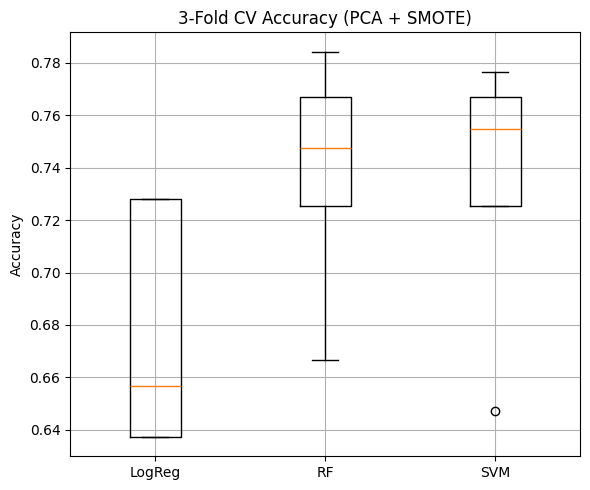

('              precision    recall  f1-score   support\n\n           0       0.50      0.11      0.18        64\n           1       0.60      0.92      0.73        92\n\n    accuracy                           0.59       156\n   macro avg       0.55      0.52      0.45       156\nweighted avg       0.56      0.59      0.50       156\n',
 array([[ 7, 57],
        [ 7, 85]]),
 array([0.76699029, 0.77669903, 0.7254902 , 0.64705882, 0.75490196]))

In [ ]:
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix
import matplotlib.pyplot as plt

# Reapplying PCA to SMOTE-resampled training set
pca = PCA(n_components=100, random_state=42)
X_train_pca_smote = pca.fit_transform(X_train_smote)
X_test_pca = pca.transform(X_test_flat)

# Defining models
lr_model = LogisticRegression(max_iter=1000, random_state=42)
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
svm_model = SVC(probability=True, random_state=42)

# Cross-validation setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Logistic Regression: Training, Prediction, and CV
lr_model.fit(X_train_pca_smote, y_train_smote)
y_lr_proba = lr_model.predict_proba(X_test_pca)[:, 1]
lr_scores = cross_val_score(lr_model, X_train_pca_smote, y_train_smote, cv=cv, scoring='accuracy')
fpr_lr, tpr_lr, _ = roc_curve(y_test_int, y_lr_proba)
auc_lr = auc(fpr_lr, tpr_lr)

# Random Forest: Training, Prediction, and CV
rf_model.fit(X_train_pca_smote, y_train_smote)
y_rf_proba = rf_model.predict_proba(X_test_pca)[:, 1]
rf_scores = cross_val_score(rf_model, X_train_pca_smote, y_train_smote, cv=cv, scoring='accuracy')
fpr_rf, tpr_rf, _ = roc_curve(y_test_int, y_rf_proba)
auc_rf = auc(fpr_rf, tpr_rf)

# SVM: Training, Prediction, Evaluation, and CV
svm_model.fit(X_train_pca_smote, y_train_smote)
y_pred_svm = svm_model.predict(X_test_pca)
y_proba_svm = svm_model.predict_proba(X_test_pca)[:, 1]
svm_scores = cross_val_score(svm_model, X_train_pca_smote, y_train_smote, cv=cv, scoring='accuracy')
fpr_svm, tpr_svm, _ = roc_curve(y_test_int, y_proba_svm)
auc_svm = auc(fpr_svm, tpr_svm)
svm_report = classification_report(y_test_int, y_pred_svm)
svm_conf_matrix = confusion_matrix(y_test_int, y_pred_svm)

# Plotting ROC Curves for All Models
plt.figure(figsize=(8, 6))
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {auc_lr:.2f})')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc_rf:.2f})')
plt.plot(fpr_svm, tpr_svm, label=f'SVM (AUC = {auc_svm:.2f})', color='purple')
plt.plot([0, 1], [0, 1], 'k--', label='Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison (PCA + SMOTE)')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

# Cross-validation boxplot for all models
plt.figure(figsize=(6, 5))
plt.boxplot([lr_scores, rf_scores, svm_scores], labels=['LogReg', 'RF', 'SVM'])
plt.title('3-Fold CV Accuracy (PCA + SMOTE)')
plt.ylabel('Accuracy')
plt.grid(True)
plt.tight_layout()
plt.show()

# Outputting SVM evaluation
svm_report, svm_conf_matrix, svm_scores


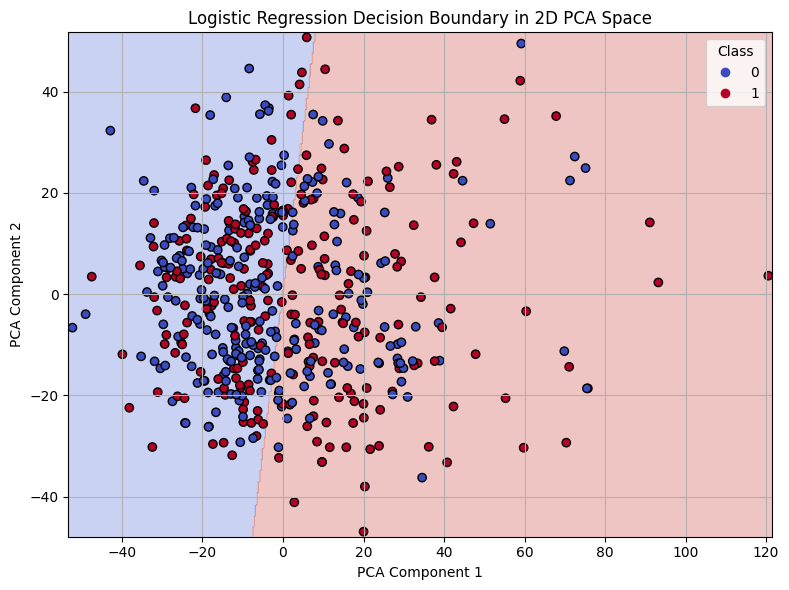

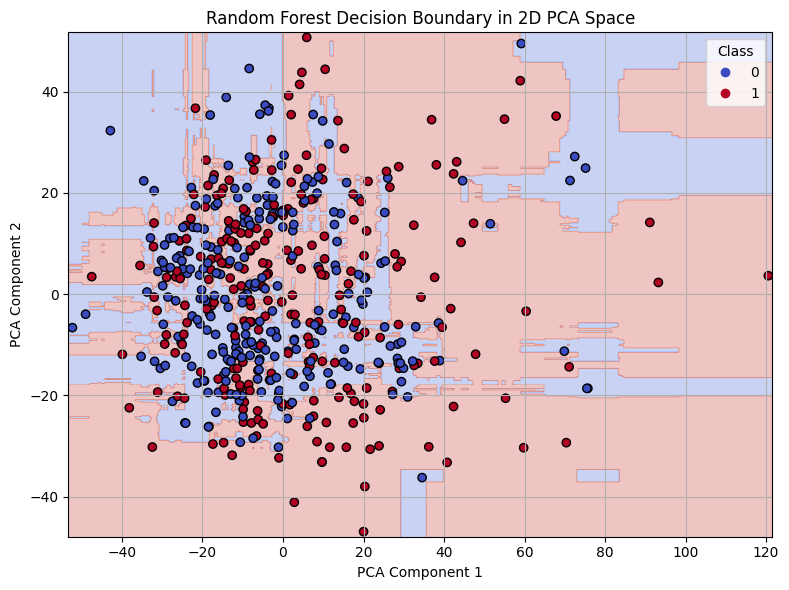

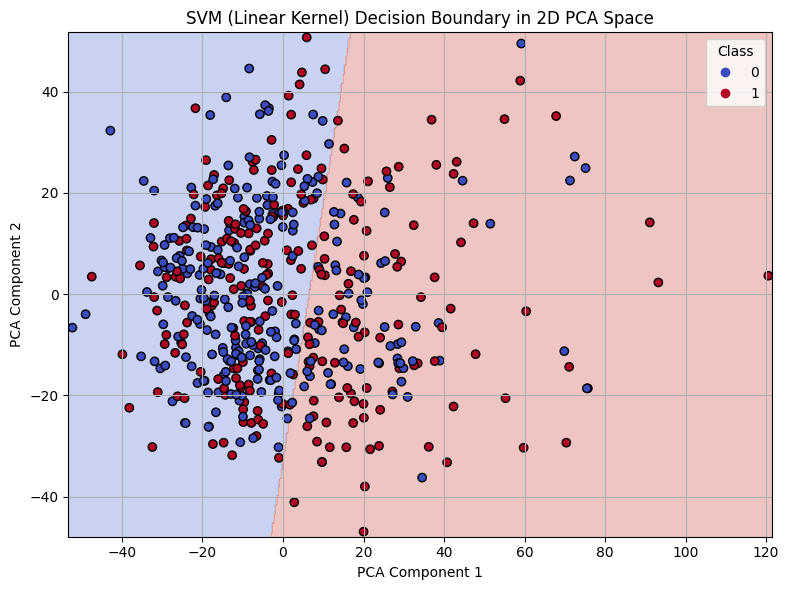

In [ ]:
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import matplotlib.pyplot as plt

# Applying 2D PCA to training data
pca_2d = PCA(n_components=2, random_state=42)
X_train_pca_2d = pca_2d.fit_transform(X_train_smote)

# Creating meshgrid for decision boundaries
x_min, x_max = X_train_pca_2d[:, 0].min() - 1, X_train_pca_2d[:, 0].max() + 1
y_min, y_max = X_train_pca_2d[:, 1].min() - 1, X_train_pca_2d[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500),
                     np.linspace(y_min, y_max, 500))
mesh_points = np.c_[xx.ravel(), yy.ravel()]

# Initializing models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "SVM (Linear Kernel)": SVC(kernel='linear', random_state=42)
}

# Plotting decision boundaries for each model
for name, model in models.items():
    model.fit(X_train_pca_2d, y_train_smote)
    Z = model.predict(mesh_points)
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.3)
    scatter = plt.scatter(X_train_pca_2d[:, 0], X_train_pca_2d[:, 1], c=y_train_smote,
                          cmap=plt.cm.coolwarm, edgecolors='k')
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.title(f"{name} Decision Boundary in 2D PCA Space")
    plt.legend(*scatter.legend_elements(), title="Class")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


                             Model   AUC  Accuracy  F1-Score
0  Logistic Regression (PCA+SMOTE)  0.49      0.51      0.47
1        Random Forest (PCA+SMOTE)  0.47      0.58      0.60
2                  SVM (PCA+SMOTE)  0.58      0.58      0.47


<Figure size 1000x600 with 0 Axes>

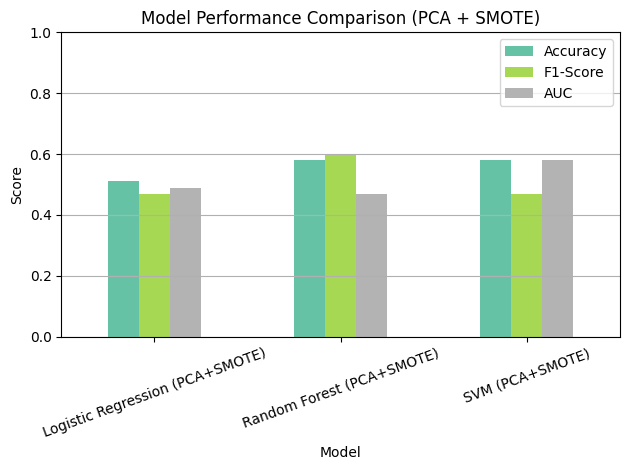

In [ ]:
import pandas as pd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Creating model performance comparison table
comparison_df = pd.DataFrame({
    'Model': ['Logistic Regression (PCA+SMOTE)', 'Random Forest (PCA+SMOTE)', 'SVM (PCA+SMOTE)'],
    'AUC': [0.49, 0.47, 0.58],
    'Accuracy': [0.51, 0.58, 0.58],
    'F1-Score': [0.47, 0.60, 0.47]
})

# Displaying the DataFrame
print(comparison_df)

#  Using Barplot for visual comparison
plt.figure(figsize=(10, 6))
comparison_df.set_index('Model')[['Accuracy', 'F1-Score', 'AUC']].plot(kind='bar', colormap='Set2')
plt.title("Model Performance Comparison (PCA + SMOTE)")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.xticks(rotation=20)
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.ensemble import VotingClassifier

ensemble = VotingClassifier(estimators=[
    ('lr', LogisticRegression()),
    ('rf', RandomForestClassifier()),
    ('svm', SVC (probability=True))
], voting='soft')

ensemble.fit(X_train_pca_smote, y_train_smote)


VotingClassifier(estimators=[('lr', LogisticRegression()),
                             ('rf', RandomForestClassifier()),
                             ('svm', SVC(probability=True))],
                 voting='soft')

In [ ]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(rf_model, X_train_pca_smote, y_train_smote, cv=5)
print("Mean CV accuracy:", scores.mean())



Mean CV accuracy: 0.7051399200456882


In [ ]:
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TimeDistributed, Conv2D, MaxPooling2D, Flatten, LSTM, Dense

# Resizing Dataset Function
def resize_dataset(data_dict, target_size=(512, 512)):
    resized_data = {}
    for class_name, images in data_dict.items():
        resized_images = []
        for img in images:
            resized = cv2.resize(img, target_size)
            resized_images.append(resized)
        resized_data[class_name] = resized_images
    return resized_data

# Preparing Dataset Function
def prepare_dataset(data_dict, class_list):
    X = []
    y = []
    for idx, class_name in enumerate(class_list):
        images = data_dict[class_name]
        X.extend(images)
        y.extend([idx] * len(images))
    return np.array(X), np.array(y)

# Preprocessing for resizing training and test sets
train_resized = resize_dataset(train_non_local_means, target_size=(512, 512))
test_resized = resize_dataset(test_non_local_means, target_size=(512, 512))

# Generating X and y
X, y = prepare_dataset(train_resized, classes)
X_test, y_test = prepare_dataset(test_resized, classes)

# Normalizing pixel values
X = X / 255.0
X_test = X_test / 255.0

# One-hot encode labels
y = to_categorical(y, num_classes=len(classes))
y_test = to_categorical(y_test, num_classes=len(classes))

# Train/Validation Splitting
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Reshaping for LSTM
X_train_lstm = X_train.reshape((X_train.shape[0], 1, 512, 512, 3))
X_val_lstm = X_val.reshape((X_val.shape[0], 1, 512, 512, 3))
X_test_lstm = X_test.reshape((X_test.shape[0], 1, 512, 512, 3))

# Defining CNN-LSTM Model
def build_cnn_lstm(input_shape=(512, 512, 3), num_classes=4):
    model = Sequential([
        TimeDistributed(Conv2D(32, (3, 3), activation='relu'), input_shape=(1,) + input_shape),
        TimeDistributed(MaxPooling2D((2, 2))),
        TimeDistributed(Flatten()),
        LSTM(64),
        Dense(64, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

cnn_lstm_model = build_cnn_lstm(input_shape=(512, 512, 3), num_classes=len(classes))

# Training the Model
cnn_lstm_model.fit(
    X_train_lstm, y_train,
    validation_data=(X_val_lstm, y_val),
    epochs=20,
    batch_size=32
)

# Assessing on Validation Set
val_loss, val_accuracy = cnn_lstm_model.evaluate(X_val_lstm, y_val)
print(f"Validation Accuracy: {val_accuracy:.2f}")

# Predicting on Test Set
y_pred_lstm = cnn_lstm_model.predict(X_test_lstm)
y_pred_labels = np.argmax(y_pred_lstm, axis=1)
y_test_int = np.argmax(y_test, axis=1)

print("LSTM Model Classification Report:")
print(classification_report(y_test_int, y_pred_labels))
print("Confusion Matrix:")
print(confusion_matrix(y_test_int, y_pred_labels))


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 77s 5s/step - accuracy: 0.5783 - loss: 1.0230 - val_accuracy: 0.4911 - val_loss: 0.7749
Epoch 2/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 57s 4s/step - accuracy: 0.5637 - loss: 0.6782 - val_accuracy: 0.5089 - val_loss: 0.6945
Epoch 3/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 56s 4s/step - accuracy: 0.4552 - loss: 0.7007 - val_accuracy: 0.4911 - val_loss: 0.7075
Epoch 4/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 56s 4s/step - accuracy: 0.5702 - loss: 0.6836 - val_accuracy: 0.4911 - val_loss: 0.7195
Epoch 5/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 56s 4s/step - accuracy: 0.5577 - loss: 0.6902 - val_accuracy: 0.4911 - val_loss: 0.6991
Epoch 6/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 57s 4s/step - accuracy: 0.5488 - loss: 0.6886 - val_accuracy: 0.4911 - val_loss: 0.7090
Epoch 7/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 56s 4s/step - accuracy: 0.5764 - loss: 0.6821 - val_accuracy: 0.4911 - val_loss: 0.7111
Epoch 8/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 56s 4s/step - accuracy: 0.6257 - loss: 0.6648 - val_accuracy: 0.4911 - val_loss:

5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 597ms/step
LSTM Model Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        64
           1       0.59      1.00      0.74        92

    accuracy                           0.59       156
   macro avg       0.29      0.50      0.37       156
weighted avg       0.35      0.59      0.44       156

Confusion Matrix:
[[ 0 64]
 [ 0 92]]


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
